<a href="https://colab.research.google.com/github/QuangMinhPhan23/emotions-classification-for-tweets/blob/main/BERT_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>1. Introduction, Motivation and Problem Statement </div></b>

The purpose of this project is to fine‑tune a pretrained Transformer‑based language model, DistilBERT, for the task of **emotion classification**.  
Given an English text input, the system predicts one of six emotions:  
`sadness`, `joy`, `love`, `anger`, `fear`, or `surprise`.

Emotion analysis is an important task for applications such as:
- Sentiment monitoring on social media
- Enhancing conversational agents
- Understanding human emotional states in text

This project leverages transfer learning to achieve good performance on this task with limited computational resources. This project is run on Google Colab, parameters are adjusted to fit the memory of Google Colab.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import numpy as np
import random
import tensorflow as tf

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

from transformers import set_seed
set_seed(seed)

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>2. Data Sources </div></b>

We use the **[`dair‑ai/emotion`](https://huggingface.co/datasets/dair-ai/emotion)** dataset hosted on HuggingFace.  
Key properties of the dataset:
- Source: HuggingFace Datasets
- Size: ~20,000 English text samples
- Splits: `train`, `validation`, and `test`
- Each example: a short sentence and its annotated emotion label
- Task: supervised multi‑class classification (6 classes)


In [ ]:
!pip install -q -U datasets


In [ ]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(




> Add blockquote



# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>3. Exploratory Analysis of the Data </div></b>



The dataset has the following characteristics:
- **Number of classes:** 6
  - `sadness`, `joy`, `love`, `anger`, `fear`, `surprise`
- **Size:**
  - Training: ~16,000 examples
  - Validation: ~2,000 examples
  - Test: ~2,000 examples

Each example is a short sentence (`text`) paired with a label (`label`) corresponding to one of the emotions above.

### Class Distribution
The distribution of classes is imbalanced.  
From the figures, we observe:
- Majority classes: *(joy)*
- Minority classes: *(surprise)*

### Sentence Length
Sentences in the dataset are relatively short, with most being around *(5-20 words)*.

### Data Preprocessing

  - Tokenization using DistilBERT’s tokenizer
  - Truncation to model max length
  - Dynamic padding to batch maximum using `DataCollatorWithPadding`

In [ ]:
emotions
emotions["train"][0]
emotions["train"].column_names
emotions["train"].features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load train set into DataFrame
df_train = pd.DataFrame(emotions["train"])

# Map labels to class names
df_train['label_name'] = df_train['label'].map(
    lambda x: emotions['train'].features['label'].int2str(x)
)

# Show first few examples
df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


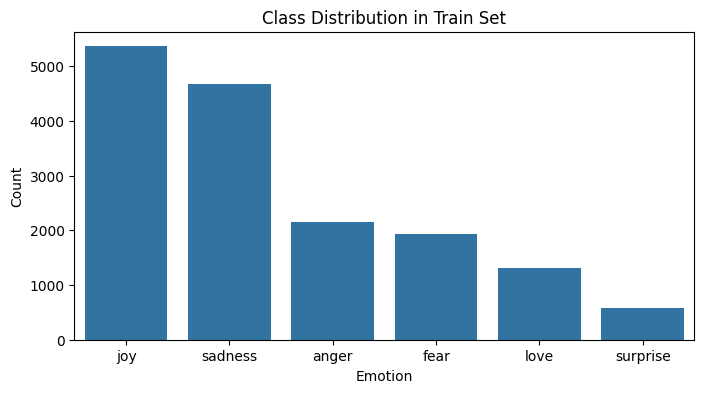

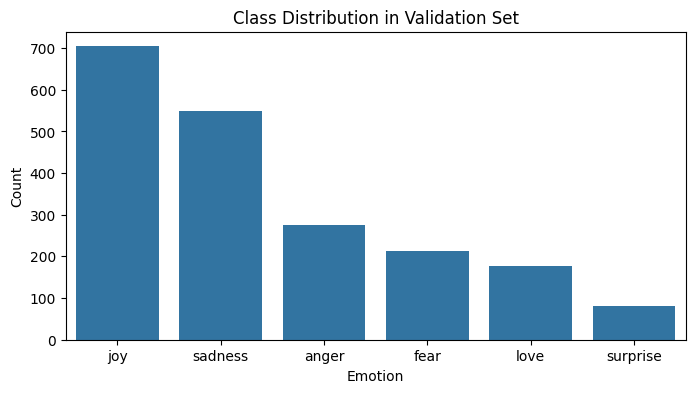

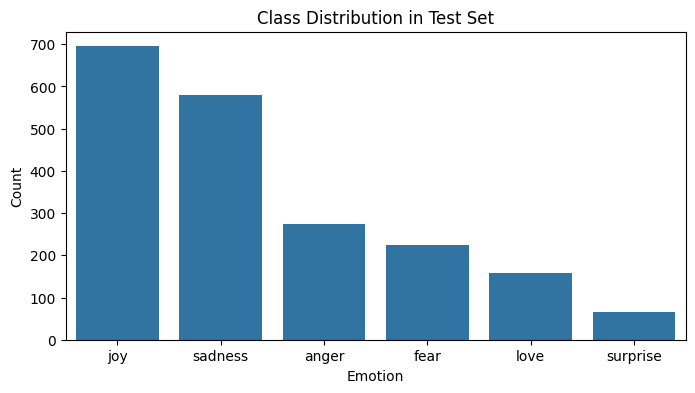

In [ ]:
def plot_class_distribution(dataset, split_name):
    df = pd.DataFrame(dataset)
    df['label_name'] = df['label'].map(
        lambda x: emotions['train'].features['label'].int2str(x)
    )
    plt.figure(figsize=(8,4))
    sns.countplot(x='label_name', data=df, order=df['label_name'].value_counts().index)
    plt.title(f'Class Distribution in {split_name} Set')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(emotions['train'], 'Train')
plot_class_distribution(emotions['validation'], 'Validation')
plot_class_distribution(emotions['test'], 'Test')

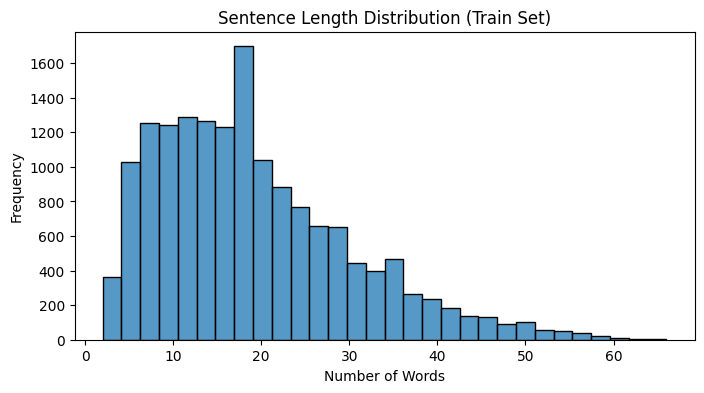

In [ ]:
df_train['text_length'] = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df_train['text_length'], bins=30, kde=False)
plt.title('Sentence Length Distribution (Train Set)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>4. Model and Methods </div></b>

The approach leverages the HuggingFace Transformers library and TensorFlow/Keras to fine‑tune a pretrained **DistilBERT** model (`distilbert‑base‑uncased`).

### Methodology:
- Load pretrained DistilBERT with classification head (`TFAutoModelForSequenceClassification`) configured for 6 output classes.
- Tokenize input text using DistilBERT tokenizer, with truncation and dynamic padding.
- Prepare TensorFlow datasets for training and validation using `prepare_tf_dataset`.
- Optimization:
  - Optimizer: Adam (`learning_rate=5e‑5`)
  - Batch size: 64
  - Epochs: 2
- Evaluation:
  - During training using `KerasMetricCallback` and a custom `compute_metrics` function
  - Metrics: accuracy, precision, recall, f1‑score (per class), confusion matrix
  - Results pushed to HuggingFace Hub using `PushToHubCallback`

The DistilBERT model was chosen for its balance of performance and computational efficiency, making it well‑suited for Colab‑scale resources.

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
    """
    Tokenizes a batch of text batch using the pre-defined tokenizer.

    Args:
        batch (dict): A dictionary with a "text" key containing a list of strings.

    Returns:
        dict: A dictionary of tokenized inputs (input_ids, attention_mask, etc.).
    """
    # Extract the list of text strings from the batch and tokenize them.
    # truncation=True ensures that sequences longer than the model's max length are cut off.
    return tokenizer(batch["text"], truncation=True)

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# add padding
from transformers import DataCollatorWithPadding

# Create a data collator that will pad the tokenized inputs to the maximum length in the batch.
data_collator=DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
!pip install -q evaluate

In [ ]:
!pip install -q matplotlib

In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute overall accuracy
    acc = accuracy.compute(predictions=predictions, references=labels)

    # Compute classification report and confusion matrix
    report = classification_report(labels, predictions, output_dict=True)
    cm = confusion_matrix(labels, predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(labels, predictions))

    # Return metrics dict for trainer
    metrics = {"accuracy": acc["accuracy"]}

    for label, scores in report.items():
        if isinstance(scores, dict):
            metrics[f"{label}_precision"] = scores["precision"]
            metrics[f"{label}_recall"] = scores["recall"]
            metrics[f"{label}_f1"] = scores["f1-score"]

    return metrics

# <b><div style='padding:15px;background-color:#850E35;color:white;border-radius:2px;font-size:110%;text-align: center'>5. Model Training </div></b>

In [ ]:
from transformers import TFAutoModelForSequenceClassification

id2label={0:"sadness",1:"joy",2:"love",3:"anger",4:"fear",5:"suprise"}
label2id={"sadness":0,"joy":1,"love":2,"anger":3,"fear":4,"suprise":5}

model=TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=6, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were n

## Preparing the datasets

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    emotions_encoded["train"],
    shuffle = True,
    batch_size = 16, # can adjust to 16 for slower training
    # collate_fn is used to pad the sequences in the batch to the same length
    collate_fn = data_collator
)

tf_validation_set = model.prepare_tf_dataset(
    emotions_encoded["validation"],
    shuffle=False,
    batch_size = 64,
    collate_fn = data_collator
)

In [ ]:
import tensorflow as tf

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) # 5e-5 can adjust to 2e-5 for slower training
model.compile(optimizer=optimizer)

## Setting the callbacks

# Results

After training for 2 epochs on a Colab GPU, the model achieved the following outcomes:

- **Validation Accuracy:** ~XX% (*replace with your actual value here, e.g. ~88%*)
- **Per‑class metrics:** Computed and displayed in a classification report (see notebook output)
- **Confusion Matrix:** Plotted, showing correct vs. incorrect predictions per class
- **Example inference:**
  - Input: `"I’m furious about what happened"`
  - Predicted: `anger` (highest confidence score)

Key findings:
- The model performed well on majority classes (`joy`, `sadness`) with high precision and recall.
- Performance was lower on minority classes (`surprise`, `love`) due to imbalance.
- Visualization of confusion matrix revealed which classes were most commonly confused.


In [ ]:
from transformers.keras_callbacks import KerasMetricCallback
from transformers.keras_callbacks import PushToHubCallback

metric_callback=KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset = tf_validation_set
)

push_to_hub_callback=PushToHubCallback(
    output_dir = "distilbert-emotion-analysis-v1",
    tokenizer = tokenizer
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/distilbert-emotion-analysis-v1 is already a clone of https://huggingface.co/haidwg/distilbert-emotion-analysis-v1. Make sure you pull the latest changes with `repo.git_pull()`.


Epoch 1/5
1000/1000 [==============================] - ETA: 0s - loss: 0.0974

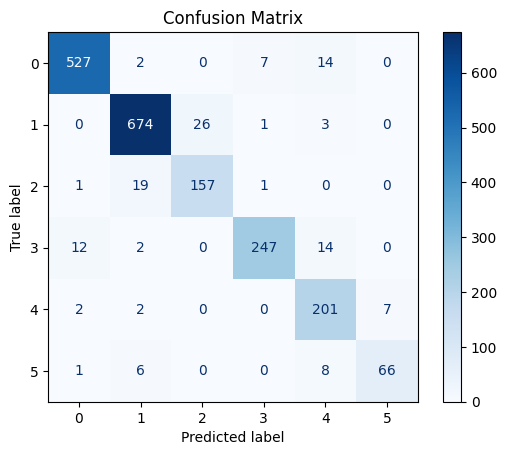

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       550
           1       0.96      0.96      0.96       704
           2       0.86      0.88      0.87       178
           3       0.96      0.90      0.93       275
           4       0.84      0.95      0.89       212
           5       0.90      0.81      0.86        81

    accuracy                           0.94      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000

1000/1000 [==============================] - 133s 133ms/step - loss: 0.0974 - val_loss: 0.1514 - accuracy: 0.9360 - 0_precision: 0.9705 - 0_recall: 0.9582 - 0_f1: 0.9643 - 1_precision: 0.9560 - 1_recall: 0.9574 - 1_f1: 0.9567 - 2_precision: 0.8579 - 2_recall: 0.8820 - 2_f1: 0.8698 - 3_precision: 0.9648 - 3_recall: 0.8982 - 3_f1: 0.9303 - 4_precision: 0.8375 - 4_recall: 0.9481 - 4_f1: 0.8894 - 5_precision: 0.9041 - 5_recall: 0.8148

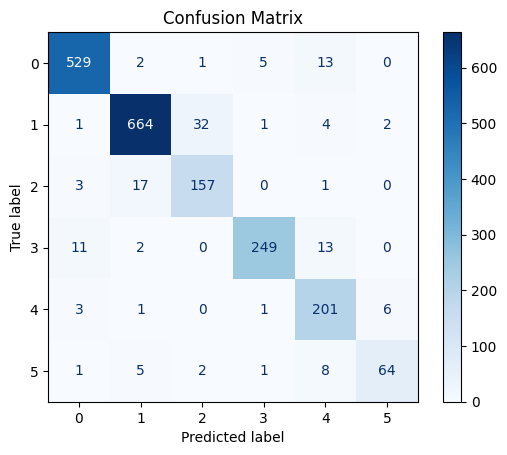

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       550
           1       0.96      0.94      0.95       704
           2       0.82      0.88      0.85       178
           3       0.97      0.91      0.94       275
           4       0.84      0.95      0.89       212
           5       0.89      0.79      0.84        81

    accuracy                           0.93      2000
   macro avg       0.91      0.91      0.90      2000
weighted avg       0.93      0.93      0.93      2000

1000/1000 [==============================] - 138s 138ms/step - loss: 0.0834 - val_loss: 0.1639 - accuracy: 0.9320 - 0_precision: 0.9653 - 0_recall: 0.9618 - 0_f1: 0.9636 - 1_precision: 0.9609 - 1_recall: 0.9432 - 1_f1: 0.9520 - 2_precision: 0.8177 - 2_recall: 0.8820 - 2_f1: 0.8486 - 3_precision: 0.9689 - 3_recall: 0.9055 - 3_f1: 0.9361 - 4_precision: 0.8375 - 4_recall: 0.9481 - 4_f1: 0.8894 - 5_precision: 0.8889 - 5_recall: 0.7901

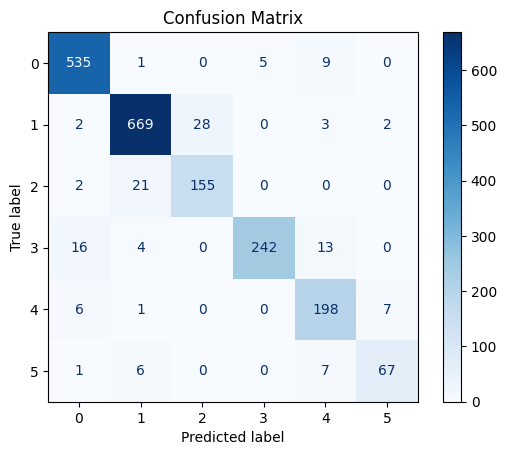

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       550
           1       0.95      0.95      0.95       704
           2       0.85      0.87      0.86       178
           3       0.98      0.88      0.93       275
           4       0.86      0.93      0.90       212
           5       0.88      0.83      0.85        81

    accuracy                           0.93      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.93      0.93      0.93      2000

1000/1000 [==============================] - 128s 128ms/step - loss: 0.0687 - val_loss: 0.1951 - accuracy: 0.9330 - 0_precision: 0.9520 - 0_recall: 0.9727 - 0_f1: 0.9622 - 1_precision: 0.9530 - 1_recall: 0.9503 - 1_f1: 0.9516 - 2_precision: 0.8470 - 2_recall: 0.8708 - 2_f1: 0.8587 - 3_precision: 0.9798 - 3_recall: 0.8800 - 3_f1: 0.9272 - 4_precision: 0.8609 - 4_recall: 0.9340 - 4_f1: 0.8959 - 5_precision: 0.8816 - 5_recall: 0.8272

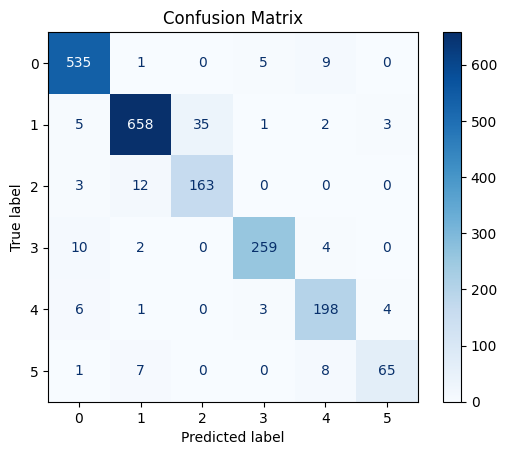

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       550
           1       0.97      0.93      0.95       704
           2       0.82      0.92      0.87       178
           3       0.97      0.94      0.95       275
           4       0.90      0.93      0.91       212
           5       0.90      0.80      0.85        81

    accuracy                           0.94      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000

1000/1000 [==============================] - 137s 137ms/step - loss: 0.0569 - val_loss: 0.1914 - accuracy: 0.9390 - 0_precision: 0.9554 - 0_recall: 0.9727 - 0_f1: 0.9640 - 1_precision: 0.9662 - 1_recall: 0.9347 - 1_f1: 0.9502 - 2_precision: 0.8232 - 2_recall: 0.9157 - 2_f1: 0.8670 - 3_precision: 0.9664 - 3_recall: 0.9418 - 3_f1: 0.9540 - 4_precision: 0.8959 - 4_recall: 0.9340 - 4_f1: 0.9145 - 5_precision: 0.9028 - 5_recall: 0.8025

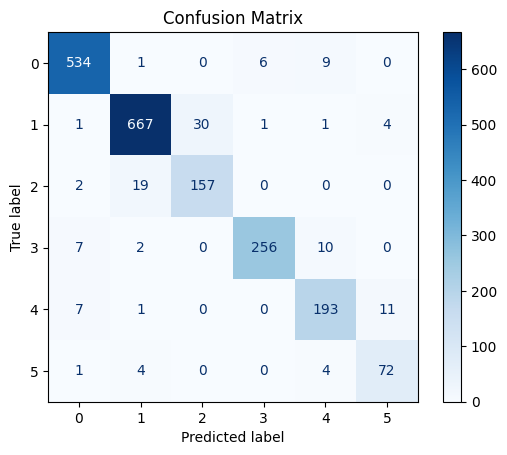

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       550
           1       0.96      0.95      0.95       704
           2       0.84      0.88      0.86       178
           3       0.97      0.93      0.95       275
           4       0.89      0.91      0.90       212
           5       0.83      0.89      0.86        81

    accuracy                           0.94      2000
   macro avg       0.91      0.92      0.92      2000
weighted avg       0.94      0.94      0.94      2000

1000/1000 [==============================] - 142s 142ms/step - loss: 0.0510 - val_loss: 0.1881 - accuracy: 0.9395 - 0_precision: 0.9674 - 0_recall: 0.9709 - 0_f1: 0.9691 - 1_precision: 0.9611 - 1_recall: 0.9474 - 1_f1: 0.9542 - 2_precision: 0.8396 - 2_recall: 0.8820 - 2_f1: 0.8603 - 3_precision: 0.9734 - 3_recall: 0.9309 - 3_f1: 0.9517 - 4_precision: 0.8894 - 4_recall: 0.9104 - 4_f1: 0.8998 - 5_precision: 0.8276 - 5_recall: 0.8889

In [ ]:
model.fit(x=tf_train_set,
         validation_data=tf_validation_set,
         epochs=5, # can adjust to 3/5 for slower training
         callbacks=[metric_callback, push_to_hub_callback])

# Test

In [ ]:
!pip install -U transformers

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("haidwg/distilbert-emotion-analysis-v1")
model = TFAutoModelForSequenceClassification.from_pretrained(
    "haidwg/distilbert-emotion-analysis-v1", from_pt=False
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some layers from the model checkpoint at haidwg/distilbert-emotion-analysis-v1 were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at haidwg/distilbert-emotion-analysis-v1 and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import pipeline

pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    framework="tf"
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Device set to use 0


In [ ]:
result = pipe("I’m furious about what happened", top_k=3)
print(result)

[{'label': 'anger', 'score': 0.9995250701904297}, {'label': 'sadness', 'score': 0.00024244243104476482}, {'label': 'joy', 'score': 0.00010775723058031872}]


## Discussion

The fine‑tuned DistilBERT model showed strong performance overall, with reliable predictions on the most frequent classes and reasonable generalization to unseen examples.

### Strengths:
- High accuracy on majority classes
- Efficient and fast fine‑tuning
- Easy deployment through HuggingFace Hub

### Weaknesses:
- Lower recall and precision on minority classes
- Limited number of epochs (only 2) may have limited full convergence

### Future work:
- Experiment with techniques to address class imbalance, such as weighted loss or oversampling.
- Train for additional epochs and tune learning rate for better convergence.
- Explore larger or more powerful models like BERT‑base or RoBERTa.


In [ ]:
!pip install -U datasets fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [ ]:
from datasets import load_dataset


In [ ]:
emotions = load_dataset("dair-ai/emotion")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
import tensorflow as tf
from datasets import load_dataset
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("haidwg/distilbert-emotion-analysis-v1")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

model = TFAutoModelForSequenceClassification.from_pretrained(
    "haidwg/distilbert-emotion-analysis-v1", from_pt=False
)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at haidwg/distilbert-emotion-analysis-v1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
def evaluate_on_test_set(model, tokenizer, emotions_encoded, data_collator, batch_size=64):
    """
    Evaluate the trained model on the test set and print metrics and confusion matrix.

    Args:
        model: trained TFAutoModelForSequenceClassification
        tokenizer: AutoTokenizer
        emotions_encoded: tokenized HuggingFace dataset
        data_collator: DataCollatorWithPadding
        batch_size: batch size for test set

    Returns:
        metrics: dict of evaluation metrics
    """
    import numpy as np

    # Prepare tf.data.Dataset for test set
    tf_test_set = model.prepare_tf_dataset(
        emotions_encoded["test"],
        shuffle=False,
        batch_size=batch_size,
        collate_fn=data_collator
    )

    # Get predictions
    preds_logits = model.predict(tf_test_set).logits

    # Get true labels
    y_true = []
    for batch in tf_test_set:
        y_true.extend(batch[1].numpy())
    y_true = np.array(y_true)

    # Compute metrics and plots
    metrics = compute_metrics((preds_logits, y_true))

    return metrics


In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
import evaluate
accuracy = evaluate.load("accuracy")

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Compute overall accuracy
    acc = accuracy.compute(predictions=predictions, references=labels)

    # Label names
    target_names = emotions['train'].features['label'].names

    # Compute classification report and confusion matrix
    report = classification_report(labels, predictions, target_names=target_names, output_dict=True)
    cm = confusion_matrix(labels, predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names=target_names))

    # Return metrics dict for trainer
    metrics = {"accuracy": acc["accuracy"]}

    for i, label in enumerate(target_names):
        scores = report[label]
        metrics[f"{label}_precision"] = scores["precision"]
        metrics[f"{label}_recall"] = scores["recall"]
        metrics[f"{label}_f1"] = scores["f1-score"]

    return metrics


32/32 [==============================] - 4s 124ms/step


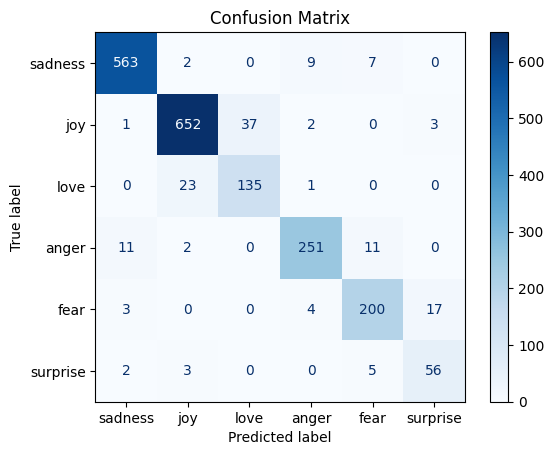

Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.96      0.94      0.95       695
        love       0.78      0.85      0.82       159
       anger       0.94      0.91      0.93       275
        fear       0.90      0.89      0.89       224
    surprise       0.74      0.85      0.79        66

    accuracy                           0.93      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
test_metrics = evaluate_on_test_set(model, tokenizer, emotions_encoded, data_collator)